# 1. Step: Import of required libraries

In this step all the libraries needed within the script are imported

In [1]:
import sys
import xlrd, xlsxwriter
import numpy as np
import pandas as pd
import time
import datetime
import scipy.io
import scipy
from scipy.sparse import csr_matrix

# 2. Step: Locating the Database Address

The database address is defined in this step.

In [2]:
ProjectSpecs_Path_Main     = 'C:/Users/ghardadi/Documents/'
ProjectSpecs_Name_ConFile  = 'MRIO_Config.xlsx'
ProjectSpecs_DataPath1     = 'C:/Users/ghardadi/EXIOBASE_2/'
ProjectSpecs_PackagePath1  = 'C:/Users/ghardadi/'

sys.path.append(ProjectSpecs_PackagePath1)

# 3. Step: Extracting the Information from Config File

In this step we collect the information from config file and start the simulation.

In [3]:
# Load project-specific config file
Project_Configfile  = xlrd.open_workbook(ProjectSpecs_Path_Main + 'Calculation/' + ProjectSpecs_Name_ConFile)
Project_Configsheet = Project_Configfile.sheet_by_name('Config')

# Naming script and defining of name specifications (e.g. date when the script was used)
Name_Script        = Project_Configsheet.cell_value(6,3)
Name_Scenario      = Project_Configsheet.cell_value(5,3)
StartTime          = datetime.datetime.now()
TimeString         = str(StartTime.year) + '_' + str(StartTime.month) + '_' + str(StartTime.day) + '__' + str(StartTime.hour) + '_' + str(StartTime.minute) + '_' + str(StartTime.second)
DateString         = str(StartTime.year) + '_' + str(StartTime.month) + '_' + str(StartTime.day)
Path_Result        = ProjectSpecs_Path_Main + 'Results/'

# Importing information about Exiobase 2.2 from excel file
EB3_NoofCountries  = int(Project_Configsheet.cell_value(4,8))
EB3_NoofProducts   = int(Project_Configsheet.cell_value(5,8))
EB3_NoofIndustries = int(Project_Configsheet.cell_value(6,8))
EB3_NoofIOSectors  = int(Project_Configsheet.cell_value(7,8))
EB3_NoofFDCategories = int(Project_Configsheet.cell_value(8,8))

# Start the timer
Time_Start = time.time()
print('Start of simulation: ' + time.asctime() + '.')

Start of simulation: Wed Feb  5 09:22:37 2020.


# 4. Step: Import Exiobase 3.6

Now, Exiobase 3.6 will be imported. This includes the following:

L-Matrix containing the Leontief-Inverse

S-Matrix containing the emissions

Y-Matrix containing the final demands

FDE-Matrix containing the direct emissions caused by the final demands

In [8]:
print('Loading Exiobase 3.6 data.')

MRIO_Name = 'EXIOBASE3_13_Mon_49R_2018_06_01_ITCpxp.mat'

Filestring_Matlab_in = ProjectSpecs_DataPath1 + MRIO_Name

print('Import L-Matrix (Leontief-Inverse)')
MRIO_L = scipy.io.loadmat(Filestring_Matlab_in)['EB3_L_ITC']

print('Import S-Matrix (Emissions).')
MRIO_S = scipy.io.loadmat(Filestring_Matlab_in)['EB3_S_ITC']

print('Import Y-Matrix (Final Demands)')
MRIO_Y = scipy.io.loadmat(Filestring_Matlab_in)['EB3_Y']

print('Import FDE-Matrix (Direct Emissions from Final Demand).')
MRIO_FDE = scipy.io.loadmat(Filestring_Matlab_in)['EB3_FinalDemand_Emissions']

print('Import the Names of Industry Sectors.')
MRIO_Prod = scipy.io.loadmat(Filestring_Matlab_in)['EB3_ProductNames200']

print('Import the Names of Extension Codes.')
MRIO_Ext = scipy.io.loadmat(Filestring_Matlab_in)['EB3_Extensions']

print('Import the Names of Regions.')
MRIO_Reg = scipy.io.loadmat(Filestring_Matlab_in)['EB3_RegionList']

Loading Exiobase 3.6 data.
Import L-Matrix (Leontief-Inverse)
Import S-Matrix (Emissions).
Import Y-Matrix (Final Demands)
Import FDE-Matrix (Direct Emissions from Final Demand).
Import the Names of Industry Sectors.
Import the Names of Extension Codes.
Import the Names of Regions.


In [9]:
Region_Datasheet = Project_Configfile.sheet_by_name('EXIOBASE 3 countries')

Region_Names = []
for m in range(0,49):
    Region_Names.append(Region_Datasheet.cell_value(m+4,5))
    
Population = []
for m in range(0,49):
    Population.append(int(Region_Datasheet.cell_value(m+4,12)))

print(Region_Names)
print()
print(Population)

['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Estonia', 'Spain', 'Finland', 'France', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Sweden', 'Slovenia', 'Slovakia', 'United Kingdom', 'United States', 'Japan', 'China', 'Canada', 'South Korea', 'Brazil', 'India', 'Mexico', 'Russia', 'Australia', 'Switzerland', 'Turkey', 'Taiwan', 'Norway', 'Indonesia', 'South Africa', 'RoW Asia and Pacific', 'RoW America', 'RoW Europe', 'RoW Africa', 'RoW Middle East']

[8479823, 11159407, 7265115, 1143866, 10334160, 80645605, 5461438, 1317997, 46620045, 5288720, 65998687, 10965211, 4255689, 9893082, 4623816, 60233948, 2957689, 543360, 2012647, 425967, 16804432, 38040196, 10457295, 19983693, 9600379, 2059953, 5413393, 64128226, 316057727, 127445000, 1357380000, 35082954, 50428893, 201035903, 1280846129, 118827161, 143506911, 23128129, 8089346, 75928564, 23374000, 50

# 5. Step: Import characterisation factors

In order to calculate the environmental footprints, characterisation factors are needed
to convert the emissions received by S. L. Y to midpoint indicators

In [10]:
print('Import characterisation factors to calculate midpoint indicators.')

ImpactFile  = xlrd.open_workbook(ProjectSpecs_DataPath1 + 'Characterization_EB36.xlsx')
ImpactSheet = ImpactFile.sheet_by_name('Emissions')
ImpactCategory_Names = []
for m in range(0,36):
    ImpactCategory_Names.append(ImpactSheet.cell_value(0,m))
    
MRIO_Char = np.zeros((36,1707))
for m in range(0,36):
    for n in range(0,1707):
        MRIO_Char[m,n] = ImpactSheet.cell_value(n+1,m+1)

Import characterisation factors to calculate midpoint indicators.


# 6. Step: Selecting the final demand vectors

The Y vector is selected based on the environmental footprints that is going to be assessed. The demand emissions are also added in the footprint calculation. The environmental footprint assessed in this study is Carbon Footprint of German households.

In [11]:
print('Import characterisation factors to calculate midpoint indicators.')

FD_DE_HH = MRIO_Y[:,EB3_NoofFDCategories*5]
DE_DE_HH = MRIO_FDE[:,EB3_NoofFDCategories*5]

Import characterisation factors to calculate midpoint indicators.


# 7. Step: Import aggregation table

In order to aggregate the environmental footprints based on consumed products, producing sectors and regions, aggregation table is needed to aggregate the detailed information of emissions into a set of aggregated sections.

In [12]:
print('Import Excel file containing aggregation table.')
# Excel file created by Gilang Hardadi based on the excel file named
# EB340_Aggregation.xlsx
AggregationFile  = xlrd.open_workbook(ProjectSpecs_DataPath1 + 'EB340_Aggregation.xlsx')

# 1) Product aggregation
ProductSheet = AggregationFile.sheet_by_name('Products')
PI = [] # Names of categories
Pv = [] # List of aggregation indices
Pa = [] # Names of aggregated categories
for m in range(0,200):
    PI.append(ProductSheet.cell_value(m+1,0))
for m in range(0,200):
    Pv.append(int(ProductSheet.cell_value(m+1,1)))
for m in range(0,12):
    Pa.append(ProductSheet.cell_value(m+1,3))

# 2a) Sector aggregation for Carbon Footprint
SectorCFSheet = AggregationFile.sheet_by_name('SectorsCF')
SCv = [] # List of aggregation indices
SCa = [] # Names of aggregated categories
for m in range(0,200):
    SCv.append(int(SectorCFSheet.cell_value(m+1,1)))
for m in range(0,6): # Read until 6 to include direct emissions
    SCa.append(SectorCFSheet.cell_value(m+1,3))

# 2b) Sector aggregation for Material Footprint
SectorMFSheet = AggregationFile.sheet_by_name('SectorsMF')
SMv = [] # List of aggregation indices
SMa = [] # Names of aggregated categories
for m in range(0,200):
    SMv.append(int(SectorMFSheet.cell_value(m+1,1)))
for m in range(0,6): # Read until 6 to include direct emissions
    SMa.append(SectorMFSheet.cell_value(m+1,3))

# 3) Region aggregation
RegionSheet = AggregationFile.sheet_by_name('Regions')
Rv = [] # List of aggregation indices
Ra = [] # Names of aggregated categories
for m in range(0,49):
    Rv.append(int(RegionSheet.cell_value(m+1,1)))
for m in range(0,6):
    Ra.append(RegionSheet.cell_value(m+1,3))

# 3) Import aggregation
ImportSheet = AggregationFile.sheet_by_name('ImportReg')
Iv = [] # List of aggregation indices
Ia = [] # Names of aggregated categories
for m in range(0,49):
    Iv.append(int(ImportSheet.cell_value(m+1,1)))
for m in range(0,2):
    Ia.append(ImportSheet.cell_value(m+1,3))

Import Excel file containing aggregation table.


In [13]:
print(SCv)
print(SCa)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 2, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 5]
['Agriculture and Food', 'Electricity and Solid Fuel', 'Material and Consumer Goods', 'Petroleum and Transportation', 'Other Services', 'Use Phase (Direct)']


# 8. Step: Calculating the emissions inventory and footprint

The inventories enlist the emissions embodied in the household consumption for each emissions type.
The footprint will show the total GHG emissions, measured in CO<sub>2</sub> equivalent.

In [14]:
def MI_Tuple(value, Is): 
    """
    Define function for obtaining multiindex tuple from index value
    value: flattened index position, Is: Number of values for each index dimension
    Example: MI_Tuple(10, [3,4,2,6]) returns [0,0,1,4]
    MI_Tuple(138, [100,10,5]) returns [2,7,3]
    MI_Tuple is the inverse of Tuple_MI.
    """
    IsValuesRev = []
    CurrentValue = value
    for m in range(0,len(Is)):
        IsValuesRev.append(CurrentValue % Is[len(Is)-m-1])
        CurrentValue = CurrentValue // Is[len(Is)-m-1]
    return IsValuesRev[::-1]    

def Tuple_MI(Tuple, IdxLength): 
    """
    Function to return the absolution position of a multiindex when the index tuple
    and the index hierarchy and size are given.
    Example: Tuple_MI([2,7,3],[100,10,5]) returns 138
    Tuple_MI([0,0,1,4],[3,4,2,6]) returns 10
    Tuple_MI is the inverse of MI_Tuple.
    """
    # First, generate the index position offset values
    IdxShift =  IdxLength[1:] +  IdxLength[:1] # Shift 1 to left
    IdxShift[-1] = 1 # Replace lowest index by 1
    IdxShift.reverse()
    IdxPosOffset = np.cumproduct(IdxShift).tolist()
    IdxPosOffset.reverse()
    Position = np.sum([a*b for a,b in zip(Tuple,IdxPosOffset)])
    return Position

def build_Aggregation_Matrix(Position_Vector): # from PySUT
    """Turn a vector of target positions into a matrix that aggregates 
    or re-arranges rows of the table it is multiplied to from the left 
    (or columns, if multiplied transposed from the right)"""
    AM_length = Position_Vector.max() + 1 # Maximum row number of new matrix (+1 to get the right length, as 0 is the smallest target position entry.)
    AM_width  = len(Position_Vector) # Number of rows of the to-be-aggregated matrix
    Rearrange_Matrix = np.zeros((AM_length,AM_width))
    for m in range(0,len(Position_Vector)):
        Rearrange_Matrix[Position_Vector[m].item(0),m] = 1 # place 1 in aggregation matrix at [PositionVector[m],m], so that column m is aggregated with Positionvector[m] in the aggregated matrix
    return Rearrange_Matrix

def build_MultiIndex_Aggregation_Matrix(Position_Vectors):
    """Turn a list of vectors of target positions that represent aggregations of the different levels of a multi-index of a table into a matrix that aggregates 
    or re-arranges rows of the multiindex table it is multiplied to from the left 
    (or columns, if multiplied transposed from the right)"""   
    OldLength = [len(i)    for i in Position_Vectors]
    NewLength = [max(i) +1 for i in Position_Vectors]
    Rearrange_Matrix = np.zeros((np.product(NewLength),np.product(OldLength)))
    for m in range(0,np.product(OldLength)):
        OldIndexTuple = MI_Tuple(m,OldLength) # convert running index to tuple (column index)
        NewIndexTuple = [Position_Vectors[i][OldIndexTuple[i]] for i in range(0,len(OldIndexTuple))] # convert unaggregated tuple to aggregated tuple
        NewIndexPos   = Tuple_MI(NewIndexTuple, NewLength)# Calculate new running index (row index)
        Rearrange_Matrix[NewIndexPos,m] = 1 # Aggregate/resort row m into row NewIndexPos.
    return Rearrange_Matrix

In [15]:
Midpoints = MRIO_Char.dot(MRIO_S)

#Build aggregation matrices:
Aggregation_MatrixC_Rows = build_MultiIndex_Aggregation_Matrix([Rv,SCv])

Aggregation_Matrix_Cols = build_MultiIndex_Aggregation_Matrix([np.zeros((49),dtype = 'int').tolist(),Pv])

print(Aggregation_MatrixC_Rows)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [17]:
pd.DataFrame(Aggregation_MatrixC_Rows)

,0,1,2,3,4,5,6,7,8,9,...,9790,9791,9792,9793,9794,9795,9796,9797,9798,9799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
pd.DataFrame(Aggregation_Matrix_Cols)

,0,1,2,3,4,5,6,7,8,9,...,9790,9791,9792,9793,9794,9795,9796,9797,9798,9799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
Footprint_Carbon_Agg = np.zeros((36,12))

X_Full = (csr_matrix(MRIO_L) * csr_matrix(np.diag(FD_DE_HH))).toarray()  # use sparse matrix algebra as numpy.dot chrashes on some machines for large matrices.
    
#Aggregate X_Full to sector x region for industries and products x 1 for products:
# First, the product groups, here, columns are aggregated, 
# which is done by multiplying the transposed aggregation matrix from the right:
X_ProdAgg = X_Full.dot(Aggregation_Matrix_Cols.transpose())
    


In [21]:
pd.DataFrame(X_ProdAgg)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.026677,13.500786,0.248978,0.017737,2.333023,0.005988,0.221702,0.127468,0.747659,0.013750,0.110620,8.253792
2,0.058819,41.040510,0.739209,0.039289,4.877737,0.013104,0.509678,0.320430,1.832203,0.031437,0.279844,9.596466
3,0.086423,49.078820,0.823687,0.033927,4.256279,0.013118,0.535065,0.246586,1.319386,0.047162,0.270703,96.731854
4,0.020535,33.552974,0.604855,0.039694,5.182372,0.011313,0.298963,0.325071,2.012774,0.012691,0.216248,24.663610
...,...,...,...,...,...,...,...,...,...,...,...,...
9795,0.018688,0.461363,0.381806,0.062139,0.347567,0.029711,0.449541,0.938184,0.863970,0.019448,0.449088,0.305710
9796,0.118365,1.013124,1.017652,0.154101,24.522550,0.060227,2.800384,0.736750,1.435926,0.052586,0.997603,0.287704
9797,0.264377,1.006384,1.336712,0.148225,0.833738,0.057219,2.313648,0.600576,12.031026,0.078228,1.166014,0.302566
9798,0.059500,0.503699,0.933831,0.064167,0.128034,0.019988,2.687717,0.550533,0.228783,0.041328,0.615769,0.255974


In [23]:
# Calculate footprint, do not sum over the industry dimension using np.einsum
Footprint_Carbon_ProdAgg_Single = np.einsum('b,bc->bc',Midpoints[4,:],X_ProdAgg) # row 4 for carbon fp
Footprint_Carbon_Agg = Aggregation_MatrixC_Rows.dot(Footprint_Carbon_ProdAgg_Single)

# Determine and add direct indicator:
Footprint_Direct_Housing_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.54))
Footprint_Direct_Transport_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.46))
Footprint_Carbon_Agg[5,3] = Footprint_Direct_Housing_Carbon # column offset 5 is for Germany direct, row 6 is for housing
Footprint_Carbon_Agg[5,10] = Footprint_Direct_Transport_Carbon # column offset 5 is for Germany direct, row 6 is for housing

RowIndexCF = pd.MultiIndex.from_product([Ra,SCa], names=('region', 'sector'))

RowDIndexICG = pd.MultiIndex.from_product([Ra,SCv], names=('region', 'sector'))

FootprintPC_Carbon_Agg = Footprint_Carbon_Agg/Population[5]

# Create dataframe:
CarbonFootprintDF_ICG = pd.DataFrame(FootprintPC_Carbon_Agg, index=RowIndexCF, columns=Pa)

In [22]:
pd.DataFrame(Footprint_Carbon_Agg)

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.824853e+06,2.789681e+10,4.849259e+07,1.172011e+07,9.261284e+08,3.188433e+06,8.266695e+07,5.971570e+08,5.583344e+08,7.771363e+05,2.131443e+07,4.628454e+09
1,3.899598e+07,9.251155e+09,1.590723e+09,3.109929e+10,3.292469e+09,5.541469e+10,7.367662e+09,6.409854e+09,8.861807e+09,8.940538e+07,7.955125e+09,1.873643e+09
2,8.196752e+06,1.375661e+09,7.643032e+08,4.424400e+08,5.807016e+08,3.340016e+08,6.171422e+09,1.631810e+10,1.616965e+09,8.920939e+06,2.059269e+09,3.182562e+08
3,1.335879e+10,1.586698e+09,1.515393e+08,2.713704e+08,8.223373e+08,3.910434e+08,8.852080e+08,2.115754e+09,1.583050e+09,2.550675e+09,1.778013e+10,3.360143e+08
4,4.417496e+08,3.051964e+09,2.506863e+08,4.234765e+09,5.136055e+09,3.120024e+08,1.554896e+09,1.766471e+10,1.486038e+10,2.930556e+08,1.349252e+09,5.309602e+08
5,0.000000e+00,0.000000e+00,0.000000e+00,1.120817e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.547701e+10,0.000000e+00
6,2.259204e+07,1.180223e+10,2.718638e+08,1.487554e+07,1.013626e+09,5.538204e+06,3.952423e+08,2.272385e+08,3.636816e+08,1.268972e+07,1.492130e+08,2.860246e+09
7,7.900630e+07,1.537499e+09,1.268427e+09,7.360072e+08,3.235334e+08,2.656827e+08,2.712421e+09,5.643497e+08,3.754442e+08,4.053324e+07,2.529847e+09,5.036862e+08
8,3.894651e+07,9.963231e+08,1.095916e+09,1.606017e+08,2.929202e+08,8.743869e+07,5.538413e+09,1.546384e+09,5.077634e+08,2.456790e+07,2.803037e+09,3.304481e+08
9,2.399762e+09,1.408078e+09,4.145656e+08,2.455899e+08,4.385282e+08,1.231976e+08,1.314027e+09,7.194845e+08,8.058303e+08,8.139044e+08,6.802471e+09,3.123960e+08


# 9. Step: Show the result

Show the Carbon Footprint per Capita

In [24]:
round(CarbonFootprintDF_ICG, 2)

Air Transportation  \
region       sector                                             
Germany      Agriculture and Food                        0.04   
             Electricity and Solid Fuel                  0.48   
             Material and Consumer Goods                 0.10   
             Petroleum and Transportation              165.65   
             Other Services                              5.48   
             Use Phase (Direct)                          0.00   
EU28+        Agriculture and Food                        0.28   
             Electricity and Solid Fuel                  0.98   
             Material and Consumer Goods                 0.48   
             Petroleum and Transportation               29.76   
             Other Services                              2.08   
             Use Phase (Direct)                          0.00   
Other Europe Agriculture and Food                        0.14   
             Electricity and Solid Fuel                  1.68   
             Material and Consumer Goods                 0.74   
             Petroleum and Transportation                9.98   
             Other Services                              0.18   
             Use Phase (Direct)                          0.00   
China        Agriculture and Food                        0.37   
             Electricity and Solid Fuel                  2.07   
             Material and Consumer Goods                 1.31   
             Petroleum and Transportation                2.66   
             Other Services                              0.04   
             Use Phase (Direct)                          0.00   
The Americas Agriculture and Food                        0.31   
             Electricity and Solid Fuel                  4.29   
             Material and Consumer Goods                 0.50   
             Petroleum and Transportation               91.46   
             Other Services                              1.69   
             Use Phase (Direct)                          0.00   
RoW          Agriculture and Food                        3.56   
             Electricity and Solid Fuel                  4.40   
             Material and Consumer Goods                 1.28   
             Petroleum and Transportation               32.07   
             Other Services                              2.89   
             Use Phase (Direct)                          0.00   

                                           Animal-based Food  \
region       sector                                            
Germany      Agriculture and Food                     345.92   
             Electricity and Solid Fuel               114.71   
             Material and Consumer Goods               17.06   
             Petroleum and Transportation              19.67   
             Other Services                            37.84   
             Use Phase (Direct)                         0.00   
EU28+        Agriculture and Food                     146.35   
             Electricity and Solid Fuel                19.06   
             Material and Consumer Goods               12.35   
             Petroleum and Transportation              17.46   
             Other Services                             7.57   
             Use Phase (Direct)                         0.00   
Other Europe Agriculture and Food                       7.92   
             Electricity and Solid Fuel                 7.79   
             Material and Consumer Goods                2.97   
             Petroleum and Transportation              13.56   
             Other Services                             0.51   
             Use Phase (Direct)                         0.00   
China        Agriculture and Food                       8.06   
             Electricity and Solid Fuel                12.20   
             Material and Consumer Goods                7.55   
             Petroleum and Transportation               1.97   
             Other Services         

## Simulating the Electricity Mix in German Household Final Demand

We are changing the demand of electricity coming from coal into electricity from PV.

In [27]:
NewFD_DE_HH = FD_DE_HH.copy()

NewFD_DE_HH[5*200+134,] += NewFD_DE_HH[5*200+127,]
NewFD_DE_HH[5*200+127,] = 0
#Elec_DE = np.diag(FD_DE_HH).dot(Aggregation_Matrix_Cols.transpose())[5*200+127:5*200+141,5]

In [28]:
print(NewFD_DE_HH.sum(axis=0))
print(FD_DE_HH.sum(axis=0))

1285004.6452252013
1285004.6452252013


In [38]:
Footprint_Carbon_Agg = np.zeros((36,12))

X_Full = (csr_matrix(MRIO_L) * csr_matrix(np.diag(NewFD_DE_HH))).toarray()  # use sparse matrix algebra as numpy.dot chrashes on some machines for large matrices.
    
#Aggregate X_Full to sector x region for industries and products x 1 for products:
# First, the product groups, here, columns are aggregated, 
# which is done by multiplying the transposed aggregation matrix from the right:
X_ProdAgg = X_Full.dot(Aggregation_Matrix_Cols.transpose())
    
# Calculate footprint, do not sum over the industry dimension using np.einsum
Footprint_Carbon_ProdAgg_Single = np.einsum('b,bc->bc',Midpoints[4,:],X_ProdAgg) # row 4 for carbon fp
Footprint_Carbon_Agg = Aggregation_MatrixC_Rows.dot(Footprint_Carbon_ProdAgg_Single)

# Determine and add direct indicator:
Footprint_Direct_Housing_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.54))
Footprint_Direct_Transport_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.46))
Footprint_Carbon_Agg[5,3] = Footprint_Direct_Housing_Carbon # column offset 5 is for Germany direct, row 6 is for housing
Footprint_Carbon_Agg[5,10] = Footprint_Direct_Transport_Carbon # column offset 5 is for Germany direct, row 6 is for housing

RowIndexCF = pd.MultiIndex.from_product([Ra,SCa], names=('region', 'sector'))

RowDIndexICG = pd.MultiIndex.from_product([Ra,SCv], names=('region', 'sector'))

FootprintPC_Carbon_Agg = Footprint_Carbon_Agg/Population[5]

# Create dataframe:
CarbonFootprintDF_ICG = pd.DataFrame(FootprintPC_Carbon_Agg, index=RowIndexCF, columns=Pa)

In [31]:
round(CarbonFootprintDF_ICG,2)

Air Transportation  \
region       sector                                             
Germany      Agriculture and Food                        0.04   
             Electricity and Solid Fuel                  0.48   
             Material and Consumer Goods                 0.10   
             Petroleum and Transportation              165.65   
             Other Services                              5.48   
             Use Phase (Direct)                          0.00   
EU28+        Agriculture and Food                        0.28   
             Electricity and Solid Fuel                  0.98   
             Material and Consumer Goods                 0.48   
             Petroleum and Transportation               29.76   
             Other Services                              2.08   
             Use Phase (Direct)                          0.00   
Other Europe Agriculture and Food                        0.14   
             Electricity and Solid Fuel                  1.68   
             Material and Consumer Goods                 0.74   
             Petroleum and Transportation                9.98   
             Other Services                              0.18   
             Use Phase (Direct)                          0.00   
China        Agriculture and Food                        0.37   
             Electricity and Solid Fuel                  2.07   
             Material and Consumer Goods                 1.31   
             Petroleum and Transportation                2.66   
             Other Services                              0.04   
             Use Phase (Direct)                          0.00   
The Americas Agriculture and Food                        0.31   
             Electricity and Solid Fuel                  4.29   
             Material and Consumer Goods                 0.50   
             Petroleum and Transportation               91.46   
             Other Services                              1.69   
             Use Phase (Direct)                          0.00   
RoW          Agriculture and Food                        3.56   
             Electricity and Solid Fuel                  4.40   
             Material and Consumer Goods                 1.28   
             Petroleum and Transportation               32.07   
             Other Services                              2.89   
             Use Phase (Direct)                          0.00   

                                           Animal-based Food  \
region       sector                                            
Germany      Agriculture and Food                     345.92   
             Electricity and Solid Fuel               114.71   
             Material and Consumer Goods               17.06   
             Petroleum and Transportation              19.67   
             Other Services                            37.84   
             Use Phase (Direct)                         0.00   
EU28+        Agriculture and Food                     146.35   
             Electricity and Solid Fuel                19.06   
             Material and Consumer Goods               12.35   
             Petroleum and Transportation              17.46   
             Other Services                             7.57   
             Use Phase (Direct)                         0.00   
Other Europe Agriculture and Food                       7.92   
             Electricity and Solid Fuel                 7.79   
             Material and Consumer Goods                2.97   
             Petroleum and Transportation              13.56   
             Other Services                             0.51   
             Use Phase (Direct)                         0.00   
China        Agriculture and Food                       8.06   
             Electricity and Solid Fuel                12.20   
             Material and Consumer Goods                7.55   
             Petroleum and Transportation               1.97   
             Other Services         

In [39]:
Bubble = pd.DataFrame(CarbonFootprintDF_ICG.sum(axis=1).unstack(), index=Ra, columns=SCa).transpose()
#SCRev = SCa[::-1]
#Bubble.sector = SCRev*6
round(Bubble,2)

,Germany,EU28+,Other Europe,China,The Americas,RoW
Agriculture and Food,431.24,212.51,18.38,55.13,125.95,286.65
Electricity and Solid Fuel,1221.56,133.34,108.79,323.18,81.94,244.66
Material and Consumer Goods,371.60,166.29,46.89,204.76,69.56,241.71
Petroleum and Transportation,516.45,195.39,205.53,28.83,181.58,236.78
Other Services,615.77,47.09,5.02,3.57,12.46,51.20
Use Phase (Direct),2573.71,0.00,0.00,0.00,0.00,0.00


In [36]:
Bubble.sum(axis=0)

Germany         5730.332152
EU28+            754.624971
Other Europe     384.621295
China            615.479457
The Americas     471.492360
RoW             1061.000489
dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

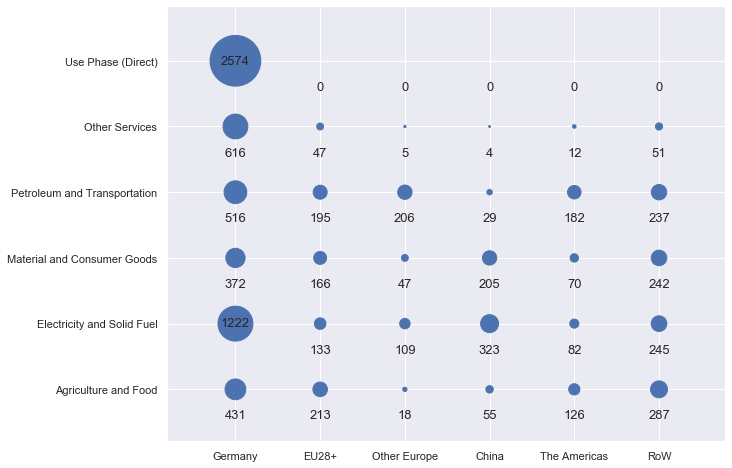

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

grid = np.meshgrid(Bubble.columns, Bubble.index)

plt.figure(figsize=(10,8))
plt.scatter(x=grid[0].flatten(), y=grid[1].flatten(), s=Bubble.values.flatten())
for i in range(0,6):
    for j in range(0,6):
        if Bubble.values.flatten()[i*6+j] >= 1000:
            plt.text(x=j, y=i, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
        else:
            plt.text(x=j, y=i-0.4, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
plt.margins(.15)
plt.show

# Modelling Import Structure of Household Goods
## Clothes, Goods, and Furniture

In this exercise, final demand vector will be modified. At LI scenario, demand from developed nations will be outsourced to the developing nations. Meanwhile, at HI scenario, demand from developing nations will be shifted back to the domestic production.

In [42]:
Clothes = np.zeros(3)
Goods = np.zeros(3)
Furniture = np.zeros(1)

LI = np.array(np.where(np.array(Iv) == 0)).astype(int)[0]
NewFD1_DE = FD_DE_HH.copy()

for k in LI:
    #Percentage share change into 1
    Clothes += 0.5*NewFD1_DE[k*200+54:k*200+57]
    NewFD1_DE[k*200+54:k*200+57] = NewFD1_DE[k*200+54:k*200+57] - 0.5*NewFD1_DE[k*200+54:k*200+57]
    Goods += 0.5*NewFD1_DE[k*200+118:k*200+121]
    NewFD1_DE[k*200+118:k*200+121] = NewFD1_DE[k*200+118:k*200+121] - 0.5*NewFD1_DE[k*200+118:k*200+121]
    Furniture += 0.5*NewFD1_DE[k*200+124]
    NewFD1_DE[k*200+124] = NewFD1_DE[k*200+124] - 0.5*NewFD1_DE[k*200+124]
        
NewFD1_DE[30*200+54:30*200+57] += Clothes #30 is the regional position for China
NewFD1_DE[30*200+118:30*200+121] += Goods
NewFD1_DE[30*200+124] += Furniture
    
    #HH_FinalDemand_MC[:,i] = HH_Demand_Industry_LowIncome


In [43]:
print(LI) #Developed Nations

[ 0  1  4  5  6  7  8  9 10 11 14 15 16 17 18 19 20 22 24 27 28 29 31 32
 37 38 40 41]


In [45]:
print(FD_DE_HH.sum(axis=0))
print(NewFD1_DE.sum(axis=0))

1285004.6452252013
1285004.6452252013


In [46]:
X_Full = (csr_matrix(MRIO_L) * csr_matrix(np.diag(NewFD1_DE))).toarray()  # use sparse matrix algebra as numpy.dot chrashes on some machines for large matrices.
    
#Aggregate X_Full to sector x region for industries and products x 1 for products:
# First, the product groups, here, columns are aggregated, 
# which is done by multiplying the transposed aggregation matrix from the right:
X_ProdAgg = X_Full.dot(Aggregation_Matrix_Cols.transpose())
    
# Calculate footprint, do not sum over the industry dimension using np.einsum
Footprint_Carbon_ProdAgg_Single = np.einsum('b,bc->bc',Midpoints[4,:],X_ProdAgg) # row 4 for carbon fp
Footprint_Carbon_Agg = Aggregation_MatrixC_Rows.dot(Footprint_Carbon_ProdAgg_Single)

# Determine and add direct indicator:
Footprint_Direct_Housing_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.54))
Footprint_Direct_Transport_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.46))
Footprint_Carbon_Agg[5,3] = Footprint_Direct_Housing_Carbon # column offset 5 is for Germany direct, row 6 is for housing
Footprint_Carbon_Agg[5,10] = Footprint_Direct_Transport_Carbon # column offset 5 is for Germany direct, row 6 is for housing

RowIndexCF = pd.MultiIndex.from_product([Ra,SCa], names=('region', 'sector'))

RowDIndexICG = pd.MultiIndex.from_product([Ra,SMv], names=('region', 'sector'))

FootprintPC_Carbon_Agg = Footprint_Carbon_Agg/80645600

# Create dataframe:
CarbonFootprintDF_ICG = pd.DataFrame(FootprintPC_Carbon_Agg, index=RowIndexCF, columns=Pa)

<function matplotlib.pyplot.show(*args, **kw)>

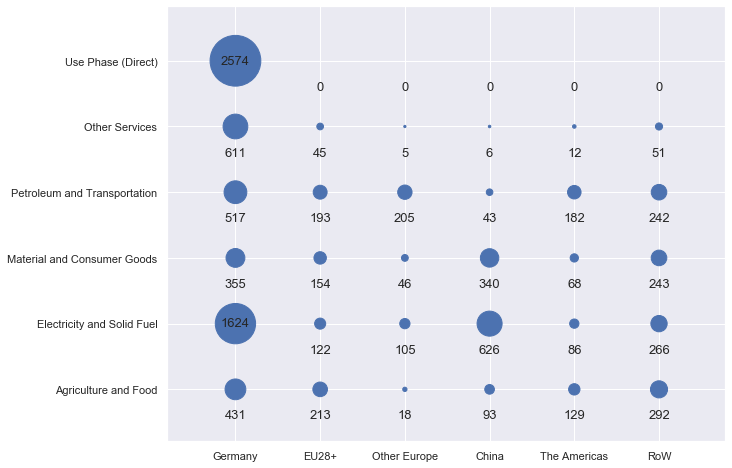

In [49]:
Bubble = pd.DataFrame(CarbonFootprintDF_ICG.sum(axis=1).unstack(), index=Ra, columns=SCa).transpose()

grid = np.meshgrid(Bubble.columns, Bubble.index)

plt.figure(figsize=(10,8))
plt.scatter(x=grid[0].flatten(), y=grid[1].flatten(), s=Bubble.values.flatten())
for i in range(0,6):
    for j in range(0,6):
        if Bubble.values.flatten()[i*6+j] >= 1000:
            plt.text(x=j, y=i, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
        else:
            plt.text(x=j, y=i-0.4, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
plt.margins(.15)
plt.show

In [56]:
Clothes = np.zeros(3)
Goods = np.zeros(3)
Furniture = np.zeros(1)

HI = np.array(np.where(np.array(Iv) == 1)).astype(int)[0]
NewFD2_DE = FD_DE_HH.copy()

for l in HI:
    Clothes += 0.5*NewFD2_DE[l*200+54:l*200+57]
    NewFD2_DE[l*200+54:l*200+57] = NewFD2_DE[l*200+54:l*200+57] - 0.5*NewFD2_DE[l*200+54:l*200+57]
    Goods += 0.5*NewFD2_DE[l*200+118:l*200+121]
    NewFD2_DE[l*200+118:l*200+121] = NewFD2_DE[l*200+118:l*200+121] - 0.5*NewFD2_DE[l*200+118:l*200+121]
    Furniture += 0.5*NewFD2_DE[l*200+124]
    NewFD2_DE[l*200+124] = NewFD2_DE[l*200+124] - 0.5*NewFD2_DE[l*200+124]
        
NewFD2_DE[5*200+54:5*200+57] += Clothes
NewFD2_DE[5*200+118:5*200+121] += Goods
NewFD2_DE[5*200+124] += Furniture
    
    #HH_FinalDemand_MC[:,i] = HH_Demand_Industry_HighIncome

In [51]:
print(HI)

[ 2  3 12 13 21 23 25 26 30 33 34 35 36 39 42 43 44 45 46 47 48]


In [57]:
print(FD_DE_HH.sum(axis=0))
print(NewFD2_DE.sum(axis=0))

1285004.6452252013
1285004.645225201


In [58]:
X_Full = (csr_matrix(MRIO_L) * csr_matrix(np.diag(NewFD2_DE))).toarray()  # use sparse matrix algebra as numpy.dot chrashes on some machines for large matrices.
    
#Aggregate X_Full to sector x region for industries and products x 1 for products:
# First, the product groups, here, columns are aggregated, 
# which is done by multiplying the transposed aggregation matrix from the right:
X_ProdAgg = X_Full.dot(Aggregation_Matrix_Cols.transpose())
    
# Calculate footprint, do not sum over the industry dimension using np.einsum
Footprint_Carbon_ProdAgg_Single = np.einsum('b,bc->bc',Midpoints[4,:],X_ProdAgg) # row 4 for carbon fp
Footprint_Carbon_Agg = Aggregation_MatrixC_Rows.dot(Footprint_Carbon_ProdAgg_Single)

# Determine and add direct indicator:
Footprint_Direct_Housing_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.54))
Footprint_Direct_Transport_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.46))
Footprint_Carbon_Agg[5,3] = Footprint_Direct_Housing_Carbon # column offset 5 is for Germany direct, row 6 is for housing
Footprint_Carbon_Agg[5,10] = Footprint_Direct_Transport_Carbon # column offset 5 is for Germany direct, row 6 is for housing

RowIndexCF = pd.MultiIndex.from_product([Ra,SCa], names=('region', 'sector'))

RowDIndexICG = pd.MultiIndex.from_product([Ra,SMv], names=('region', 'sector'))

FootprintPC_Carbon_Agg = Footprint_Carbon_Agg/80645600

# Create dataframe:
CarbonFootprintDF_ICG = pd.DataFrame(FootprintPC_Carbon_Agg, index=RowIndexCF, columns=Pa)

<function matplotlib.pyplot.show(*args, **kw)>

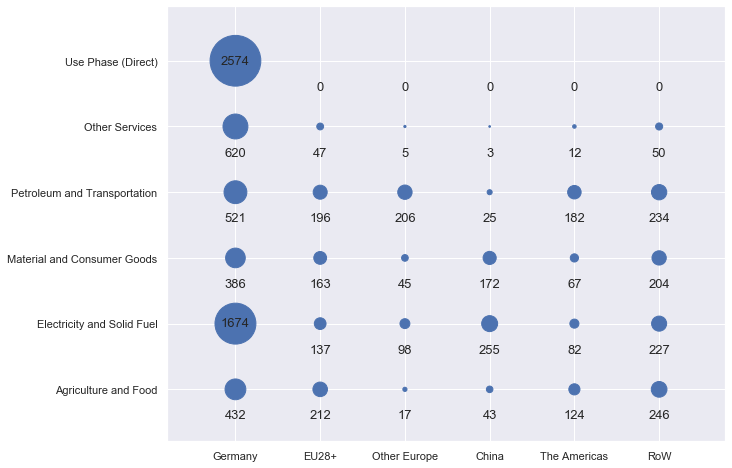

In [59]:
Bubble = pd.DataFrame(CarbonFootprintDF_ICG.sum(axis=1).unstack(), index=Ra, columns=SCa).transpose()

grid = np.meshgrid(Bubble.columns, Bubble.index)

plt.figure(figsize=(10,8))
plt.scatter(x=grid[0].flatten(), y=grid[1].flatten(), s=Bubble.values.flatten())
for i in range(0,6):
    for j in range(0,6):
        if Bubble.values.flatten()[i*6+j] >= 1000:
            plt.text(x=j, y=i, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
        else:
            plt.text(x=j, y=i-0.4, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
plt.margins(.15)
plt.show

In [60]:
Bubble.sum(axis=0).sum(axis=0)

9257.442797276042

<function matplotlib.pyplot.show(*args, **kw)>

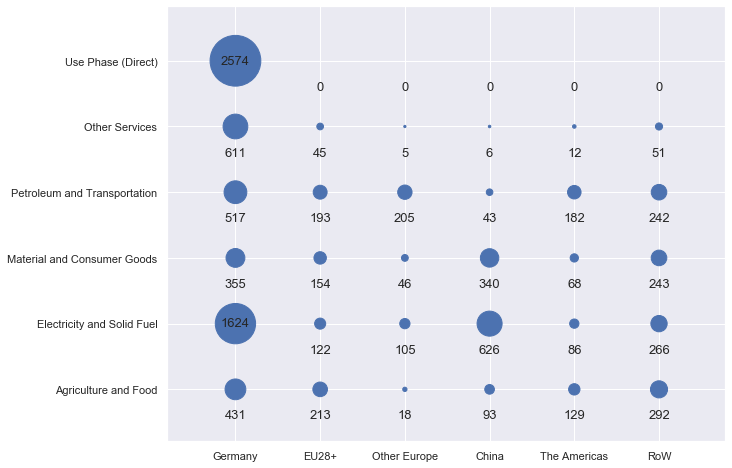

In [18]:
Bubble = pd.DataFrame(CarbonFootprintDF_ICG.sum(axis=1).unstack(), index=Ra, columns=SCa).transpose()
grid = np.meshgrid(Bubble.columns, Bubble.index)

plt.figure(figsize=(10,8))
plt.scatter(x=grid[0].flatten(), y=grid[1].flatten(), s=Bubble.values.flatten())
for i in range(0,6):
    for j in range(0,6):
        if Bubble.values.flatten()[i*6+j] >= 1000:
            plt.text(x=j, y=i, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
        else:
            plt.text(x=j, y=i-0.4, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
plt.margins(.15)
plt.show

In [61]:
Food = np.zeros(11)
Clothes = np.zeros(3)
Goods = np.zeros(3)
Furniture = np.zeros(1)

HI = np.array(np.where(np.array(Iv) == 1)).astype(int)[0]
NewFD2_DE = FD_DE_HH.copy()

for l in HI:
    Food += 0.5*NewFD2_DE[l*200+42:l*200+53]
    NewFD2_DE[l*200+42:l*200+53] = NewFD2_DE[l*200+42:l*200+53] - 0.5*NewFD2_DE[l*200+42:l*200+53]

    Clothes += 0.5*NewFD2_DE[l*200+54:l*200+57]
    NewFD2_DE[l*200+54:l*200+57] = NewFD2_DE[l*200+54:l*200+57] - 0.5*NewFD2_DE[l*200+54:l*200+57]
    Goods += 0.5*NewFD2_DE[l*200+118:l*200+121]
    NewFD2_DE[l*200+118:l*200+121] = NewFD2_DE[l*200+118:l*200+121] - 0.5*NewFD2_DE[l*200+118:l*200+121]
    Furniture += 0.5*NewFD2_DE[l*200+124]
    NewFD2_DE[l*200+124] = NewFD2_DE[l*200+124] - 0.5*NewFD2_DE[l*200+124]
        
NewFD2_DE[5*200+42:5*200+53] += Food
NewFD2_DE[5*200+54:5*200+57] += Clothes
NewFD2_DE[5*200+118:5*200+121] += Goods
NewFD2_DE[5*200+124] += Furniture
    
    #HH_FinalDemand_MC[:,i] = HH_Demand_Industry_HighIncome

In [62]:
print(FD_DE_HH.sum(axis=0))
print(NewFD2_DE.sum(axis=0))

1285004.6452252013
1285004.6452252008


In [63]:
X_Full = (csr_matrix(MRIO_L) * csr_matrix(np.diag(NewFD2_DE))).toarray()  # use sparse matrix algebra as numpy.dot chrashes on some machines for large matrices.
    
#Aggregate X_Full to sector x region for industries and products x 1 for products:
# First, the product groups, here, columns are aggregated, 
# which is done by multiplying the transposed aggregation matrix from the right:
X_ProdAgg = X_Full.dot(Aggregation_Matrix_Cols.transpose())
    
# Calculate footprint, do not sum over the industry dimension using np.einsum
Footprint_Carbon_ProdAgg_Single = np.einsum('b,bc->bc',Midpoints[4,:],X_ProdAgg) # row 4 for carbon fp
Footprint_Carbon_Agg = Aggregation_MatrixC_Rows.dot(Footprint_Carbon_ProdAgg_Single)

# Determine and add direct indicator:
Footprint_Direct_Housing_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.54))
Footprint_Direct_Transport_Carbon = (MRIO_Char[4,:].dot(MRIO_FDE[:,35]*0.46))
Footprint_Carbon_Agg[5,3] = Footprint_Direct_Housing_Carbon # column offset 5 is for Germany direct, row 6 is for housing
Footprint_Carbon_Agg[5,10] = Footprint_Direct_Transport_Carbon # column offset 5 is for Germany direct, row 6 is for housing

RowIndexCF = pd.MultiIndex.from_product([Ra,SCa], names=('region', 'sector'))

RowDIndexICG = pd.MultiIndex.from_product([Ra,SMv], names=('region', 'sector'))

FootprintPC_Carbon_Agg = Footprint_Carbon_Agg/80645600

# Create dataframe:
CarbonFootprintDF_ICG = pd.DataFrame(FootprintPC_Carbon_Agg, index=RowIndexCF, columns=Pa)

<function matplotlib.pyplot.show(*args, **kw)>

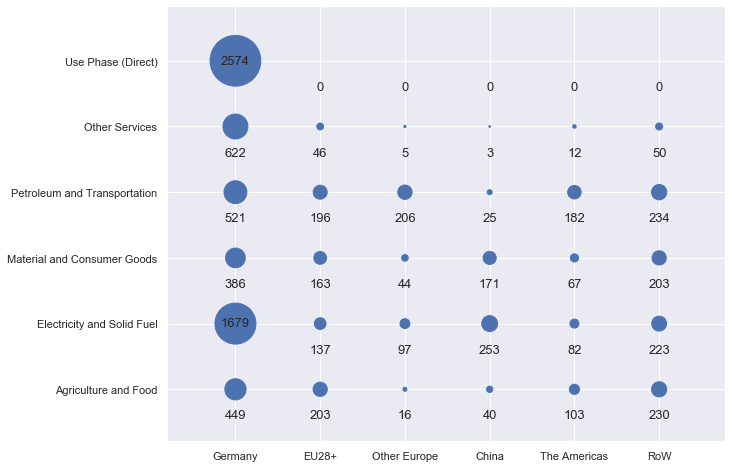

In [64]:
Bubble = pd.DataFrame(CarbonFootprintDF_ICG.sum(axis=1).unstack(), index=Ra, columns=SCa).transpose()
grid = np.meshgrid(Bubble.columns, Bubble.index)

plt.figure(figsize=(10,8))
plt.scatter(x=grid[0].flatten(), y=grid[1].flatten(), s=Bubble.values.flatten())
for i in range(0,6):
    for j in range(0,6):
        if Bubble.values.flatten()[i*6+j] >= 1000:
            plt.text(x=j, y=i, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
        else:
            plt.text(x=j, y=i-0.4, s=int(round(Bubble.values.flatten()[i*6+j])), fontsize=13, ha='center', va='center')
plt.margins(.15)
plt.show

In [65]:
print('Script is finished. Terminating logging process and closing all log files.')
Time_End = time.time()
Time_Duration = Time_End - Time_Start

print('End of simulation: ' + time.asctime() + '.')
print('Duration of simulation: %.1f seconds.' % Time_Duration)

Script is finished. Terminating logging process and closing all log files.
End of simulation: Wed Feb  5 11:35:50 2020.
Duration of simulation: 7993.9 seconds.
